# Examples of melt() and wide_to_long()

* melt() - 
* wide_to_long() - https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.wide_to_long.html

In [ ]:
import pandas as pd

In [ ]:
url = 'https://coronadatascraper.com/timeseries-tidy.csv.zip'

In [ ]:
covid = pd.read_csv(url)

In [ ]:
covid.head()

In [ ]:
covid_dc = covid[(covid['type'] == 'cases') | (covid['type'] == 'deaths')]

In [ ]:
covid_dc['entry'] = covid_dc['type'].str[0].str.upper() + covid_dc['date']

In [ ]:
covid_wide = covid_dc.pivot(index='name', columns='entry', values='value').fillna(0)

In [ ]:
covid_wide.to_csv('covid_wide.csv')

---

## Going wide to long

The wide_to_long() convenience function does a good job making it easy to take a large number of columns and pivoting them down to rows.  This is especially useful when data has been denormalized based on some whole category of values, for instance when you have one column per day rather than one row per day.

Some reasons to do this:
* When the number of columns is variable, they're sometimes easier to work with as rows.  For example, in aggregation.
* Parallelism typically is applied on multiple _rows_ rather than _columns_

---

In [ ]:
import pandas as pd
covid_wide = pd.read_csv('/data/covid_wide.csv')

In [ ]:
covid_wide.head()

In [ ]:
covid_long = pd.wide_to_long(covid_wide, stubnames=["C","D"], i='name', j='date', suffix='[\d-]+')

In [ ]:
pd.options.display.max_rows
pd.set_option('display.max_rows', None)

In [ ]:
covid_long[covid_long['name'] == '(unassigned), Arkansas, United States']

In [ ]:
covid_long.groupby('date').sum().cumsum().plot()

In [ ]:
covid_long.columns=['cases','deaths']
covid_long.to_csv('covid_long.csv')

---

# Melting.... I'm melting!!

I think the best example of when you want to melt a data frame is when you have a few columns (typically different measures) and you want to create one row per measure instead of one column per measure.

Some reasons to do this:
* You'll often find this kind of normalized data structure in a relational database.  It makes it easier to extend the data model with new measures.
* Some statistical analyses and plotting libraries work better with the "series" being defined by values in a particular column.

---

In [1]:
import pandas as pd
covid = pd.read_csv('/data/covid_long.csv')

In [2]:
covid.head()

,name,date,cases,deaths
0,"(unassigned), Arkansas, United States",2020-01-22,0.0,0.0
1,"(unassigned), Florida, United States",2020-01-22,0.0,0.0
2,"(unassigned), Georgia, United States",2020-01-22,0.0,0.0
3,"(unassigned), Illinois, United States",2020-01-22,0.0,0.0
4,"(unassigned), Louisiana, United States",2020-01-22,0.0,0.0


In [3]:
covid.shape

(295032, 4)

In [ ]:
covid.melt(id_vars=['name','date'], value_vars=['cases','deaths'], var_name='measure', value_name='count')

In [4]:
covid_really_long = covid.melt(id_vars=['name','date'], value_vars=covid.columns[2:], var_name='measure', value_name='count')

In [5]:
covid_really_long.head()

,name,date,measure,count
0,"(unassigned), Arkansas, United States",2020-01-22,cases,0.0
1,"(unassigned), Florida, United States",2020-01-22,cases,0.0
2,"(unassigned), Georgia, United States",2020-01-22,cases,0.0
3,"(unassigned), Illinois, United States",2020-01-22,cases,0.0
4,"(unassigned), Louisiana, United States",2020-01-22,cases,0.0


In [6]:
covid_really_long[(covid_really_long['date'] == '2020-03-02') & (covid_really_long['name'] == '(unassigned), Arkansas, United States') ]

,name,date,measure,count
155280,"(unassigned), Arkansas, United States",2020-03-02,cases,0.0
450312,"(unassigned), Arkansas, United States",2020-03-02,deaths,0.0


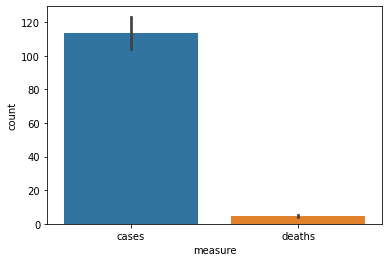

In [8]:
import seaborn as sns
sns.barplot(data=covid_really_long, x='measure', y='count')

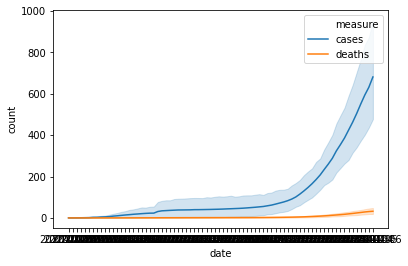

In [9]:
ax = sns.lineplot(data=covid_really_long, x='date', y='count', hue='measure')

---

# Indexing / Accessing Data 

https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html

---

In [68]:
d = {'locations': ['KS','MO','KY','IN','AL'], 
     'tests': [293, 882, 345, 823, 340], 
     'cases': [19, 22, 12, 29, 33], 
     'deaths': [3, 2, 5, 7, 12]}
df = pd.DataFrame(data=d)

In [69]:
df

,locations,tests,cases,deaths
0,KS,293,19,3
1,MO,882,22,2
2,KY,345,12,5
3,IN,823,29,7
4,AL,340,33,12


## Slicing Columns (Series)

To extract just a few columns from this data frame, we can use the syntax `df[['col1','col2','col3']]`

In [70]:
df[['locations','cases']]

,locations,cases
0,KS,19
1,MO,22
2,KY,12
3,IN,29
4,AL,33


If you extract just one column, you'll get a Series back instead of a DataFrame

In [71]:
df['locations']

0    KS
1    MO
2    KY
3    IN
4    AL
Name: locations, dtype: object

## Slicing Rows

To extract a few roles based on their label / index, you can specify those numbers in exactly the same way that you slice a list.

In [72]:
df[0:2]

,locations,tests,cases,deaths
0,KS,293,19,3
1,MO,882,22,2


## Using .loc[]

The `.loc[]` function for a dataframe allows you select particular columns (Series) and rows based on their names.  This is often the same as using the slice (`[]`) syntax but it also works when you have row labels that are not numeric.  For example, I'm first going to convert the "locations" column into our row label.

In [73]:
df = df.set_index('locations')
df

,tests,cases,deaths
locations,,,
KS,293,19,3
MO,882,22,2
KY,345,12,5
IN,823,29,7
AL,340,33,12


In this example, if we just ask for `df.loc['KS']` we will get a Series that has all of the columns for the row "named" 'KS'.

In [74]:
df.loc['KS']

tests     293
cases      19
deaths      3
Name: KS, dtype: int64

We can do that for multiple rows as well.  Some things that might be confusing relative to other ways we've used the slicing syntax.
* When slicing by label, you get both the start and end values
* The "order" is not alphanumeric, but whatever order the data is in the data frame itself

In [75]:
df.loc['KS':'MO']

,tests,cases,deaths
locations,,,
KS,293,19,3
MO,882,22,2


You can even grab slices of rows and columns at the same time using the following syntax:

`df.loc[start_row:end_row, start_column:end_column]`

In [76]:
df.loc['KS':'MO','cases':]

,cases,deaths
locations,,
KS,19,3
MO,22,2


## Using .iloc[]

The `.iloc[]` function is similar to `.loc[]` but expects row and column numbers instead of label values.  Again, somewhat counter-intuitively, with `.iloc[]` we switch back to the "up to but not including" interpretation of the end value.

`df.iloc[start_row_pos:stop_row_pos, start_column_pos:stop_column_pos]`

In [77]:
df.iloc[0:2, 1:]

,cases,deaths
locations,,
KS,19,3
MO,22,2


---

# Selecting Rows / Querying

---

In [78]:
covid.head()

,name,date,cases,deaths
0,"(unassigned), Arkansas, United States",2020-01-22,0.0,0.0
1,"(unassigned), Florida, United States",2020-01-22,0.0,0.0
2,"(unassigned), Georgia, United States",2020-01-22,0.0,0.0
3,"(unassigned), Illinois, United States",2020-01-22,0.0,0.0
4,"(unassigned), Louisiana, United States",2020-01-22,0.0,0.0


In [79]:
date_filter = (covid['date'] >= '2020-01-22') & (covid['date'] <= '2020-02-01')
covid[date_filter].shape

(42702, 4)

In [80]:
covid.query('date >= "2020-01-02" and date <= "2020-02-01"').shape

(42702, 4)